In [ ]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [ ]:
# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from train import *
from visualize_data import *
from utils import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis


# State-Action Pair Guideline

Specify the desired state-action pair:

i.e. Before Pickup, Before Discard: Draw (bpbd_draw)

## Model Name Guideline

Specify the following parameters:

- **Data Selection**:
 - **`state-action pair`**
   - possible state-action pairs
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - **`model_name`**
   - name of the model based on **pruned states** and **chosen action**
 - **`numGames`**
   - Number of games used to train model
$$numGames \in [2000, 6000, 8000]$$

 - **`pruneStatesList`**
   - which states to omit when training model 
 ```r
 pruneStatesList is a list, {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - **`actionChoice`**
   - which specific action to train model 
```r
actionChoice is one of {'all','draw','discard','knock'}
```
 - **`balance`** (T/F, **`default = False`**)
   - balance data by smallest class

--- 

- **Model Parameters**:

| Parameter         | Description                | Type             | Default |
| ----------------- |---------------------------:|:----------------:| -------:|
| **batch_size**    | num samples per iteration  | int              | 1000    |
| **learning_rate** | step size of model         | float            | 0.001   |
| **epoch**         | num of iterations          | int              | 100     |
| **model_fnc**     | model selection            | str              | MLP_base|
| **activation**    | model activation fcn       | str              | sig     |
| **loss**          | loss function selection    | str              | MSE     |
| **loss_weight**   | weighted loss (CELoss only)| str              | None    |
| **pre_train**     | initialize model weights   | bool             | False   |
| **model_PT**      | path to pretrained network | str (model/path) | null    |
| **device**        | device to train/test model | str (cpu/cuda)   | cpu     |
| **multi_data_pth**| extra data to train model  | dict             | { }     |

 - **`model_fnc`**
```r
# default
MLP_base = {1 Hidden Layer:
            input_size -> input_size*2 -> output_size,
            Activation (b/w Layers): 'Sigmoid' (default)
            Final Activation: 'Softmax'}
# Additional Models
MLP_2HL = {2 Hidden Layers:
            input_size -> input_size*2 -> input_size*2 -> output_size,
            Activation (b/w Layers): 'Sigmoid' (default)
            Final Activation: 'Softmax'} 
```

 - **`activation`**
```r
activation = {'sig': torch.nn.Sigmoid(), # default
             'relu': torch.nn.ReLU(),
             'tanh': torch.nn.Tanh()}
```

 - **`loss`**
```r
loss = {'MSE': torch.nn.MSELoss(), # default
        'CELoss': torch.nn.CrossEntropyLoss()} 
```

 - **`loss_weight`** (CELoss only)
```r
loss_weight = {None: np.ones(output_size), # default
            'icf': inverse class frequency,
            'log_icf': log inverse class frequency} 
```

 - **`multi_data_pth`**
```r
multi_data_pth {'First Path': 'data_path_1',
                'Second Path': 'data_path_2',
                ...}
where 'data_path_x' is of the form {'pth'}/data/{'state'}/{'action'}
and state/action are legal state_action pairs
```

# All

## all_states_all_actions

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth {'First Path': data_path_1,
#                 'Second Path': data_path_2,
#                 ...}
# ex. multi_data_pth = {'data_pth1': '{}/data/{}/{}'.format(pth,'apbd','knock')}
# where data_path_x is of the form {pth}/data/{state}/{action}
# and state/action are legal state_action pairs
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


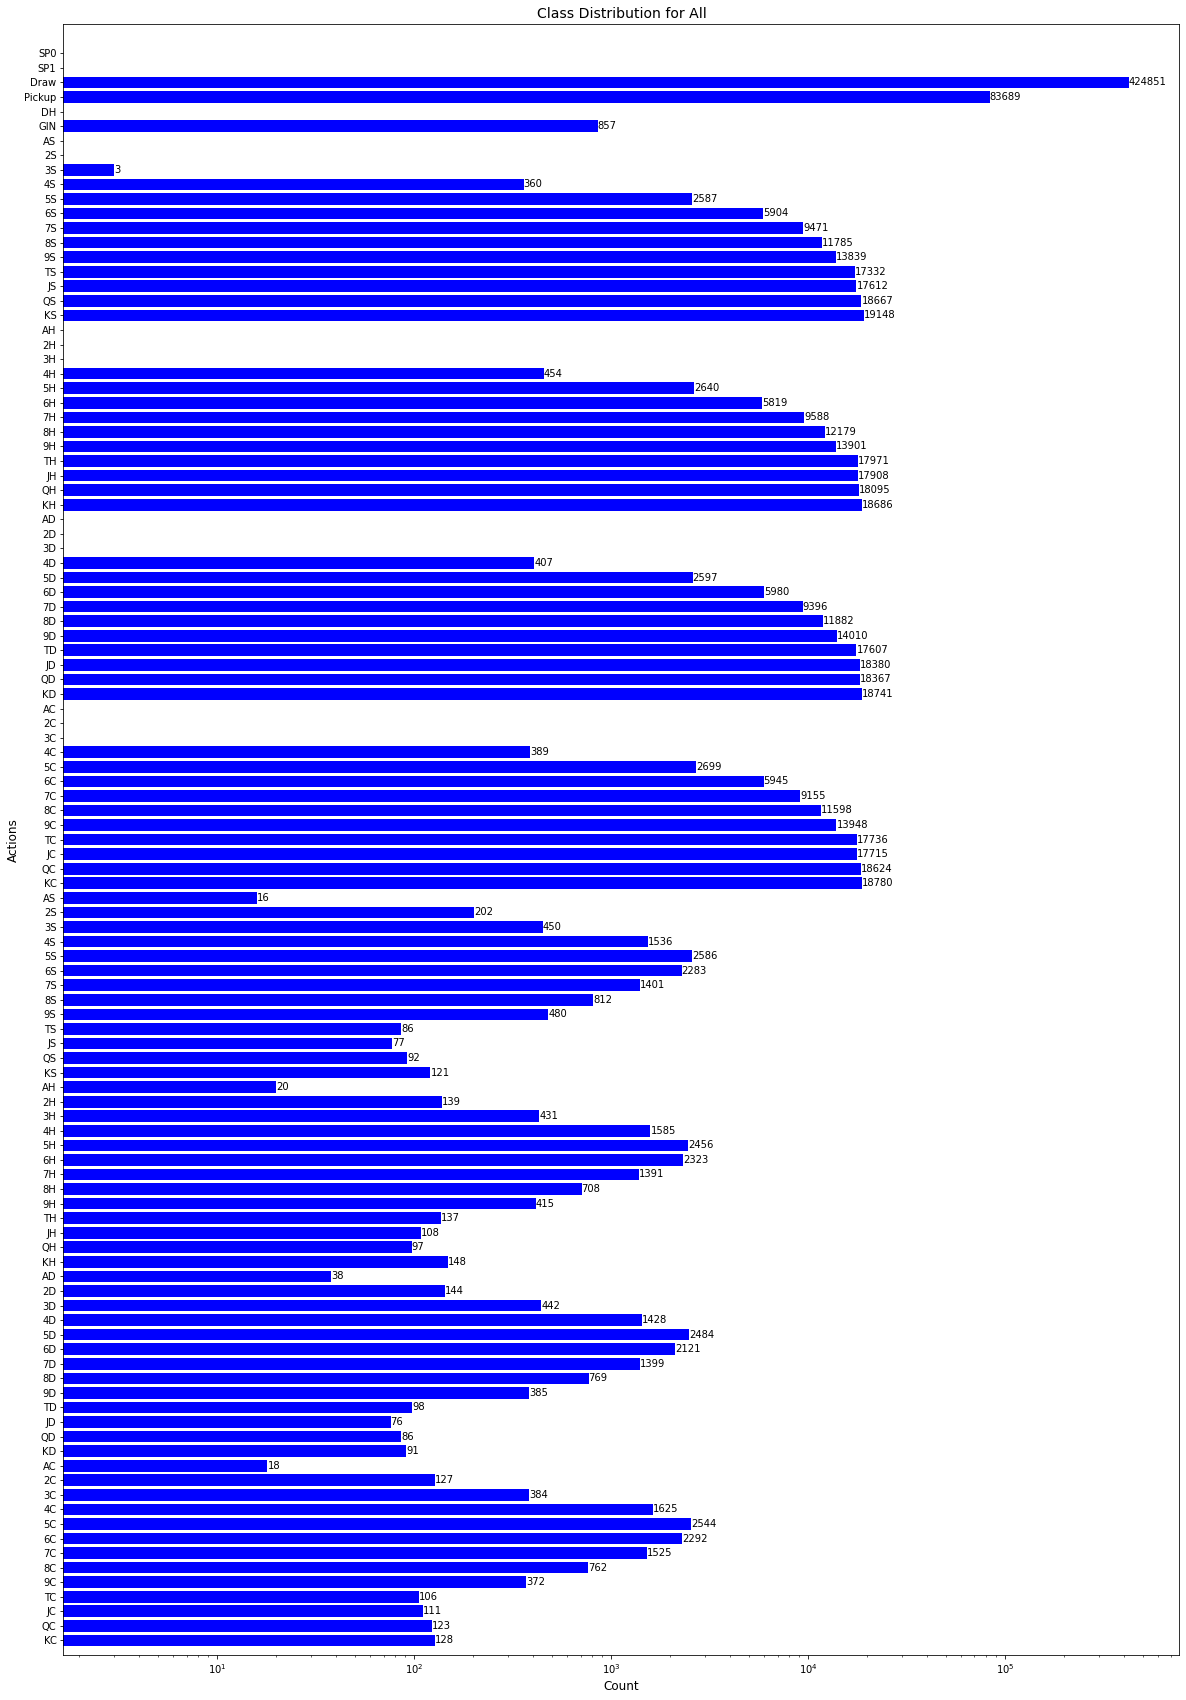

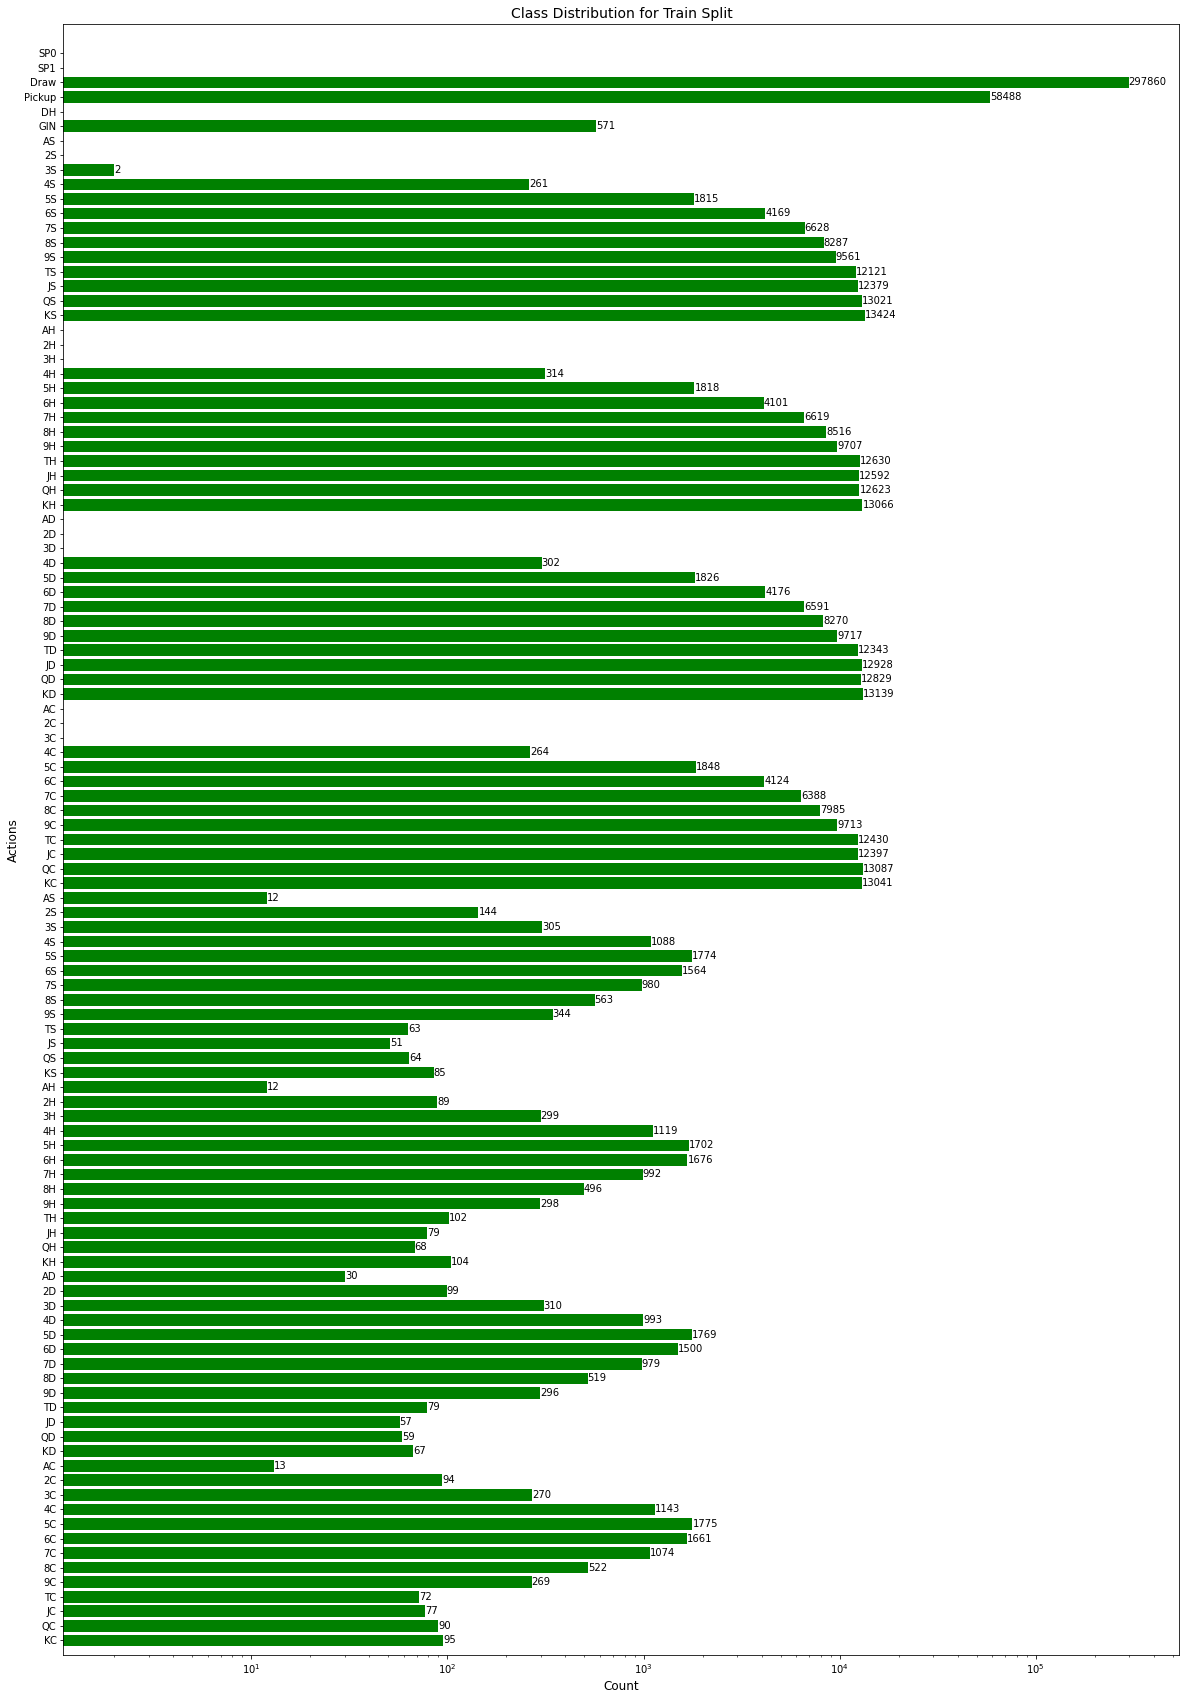

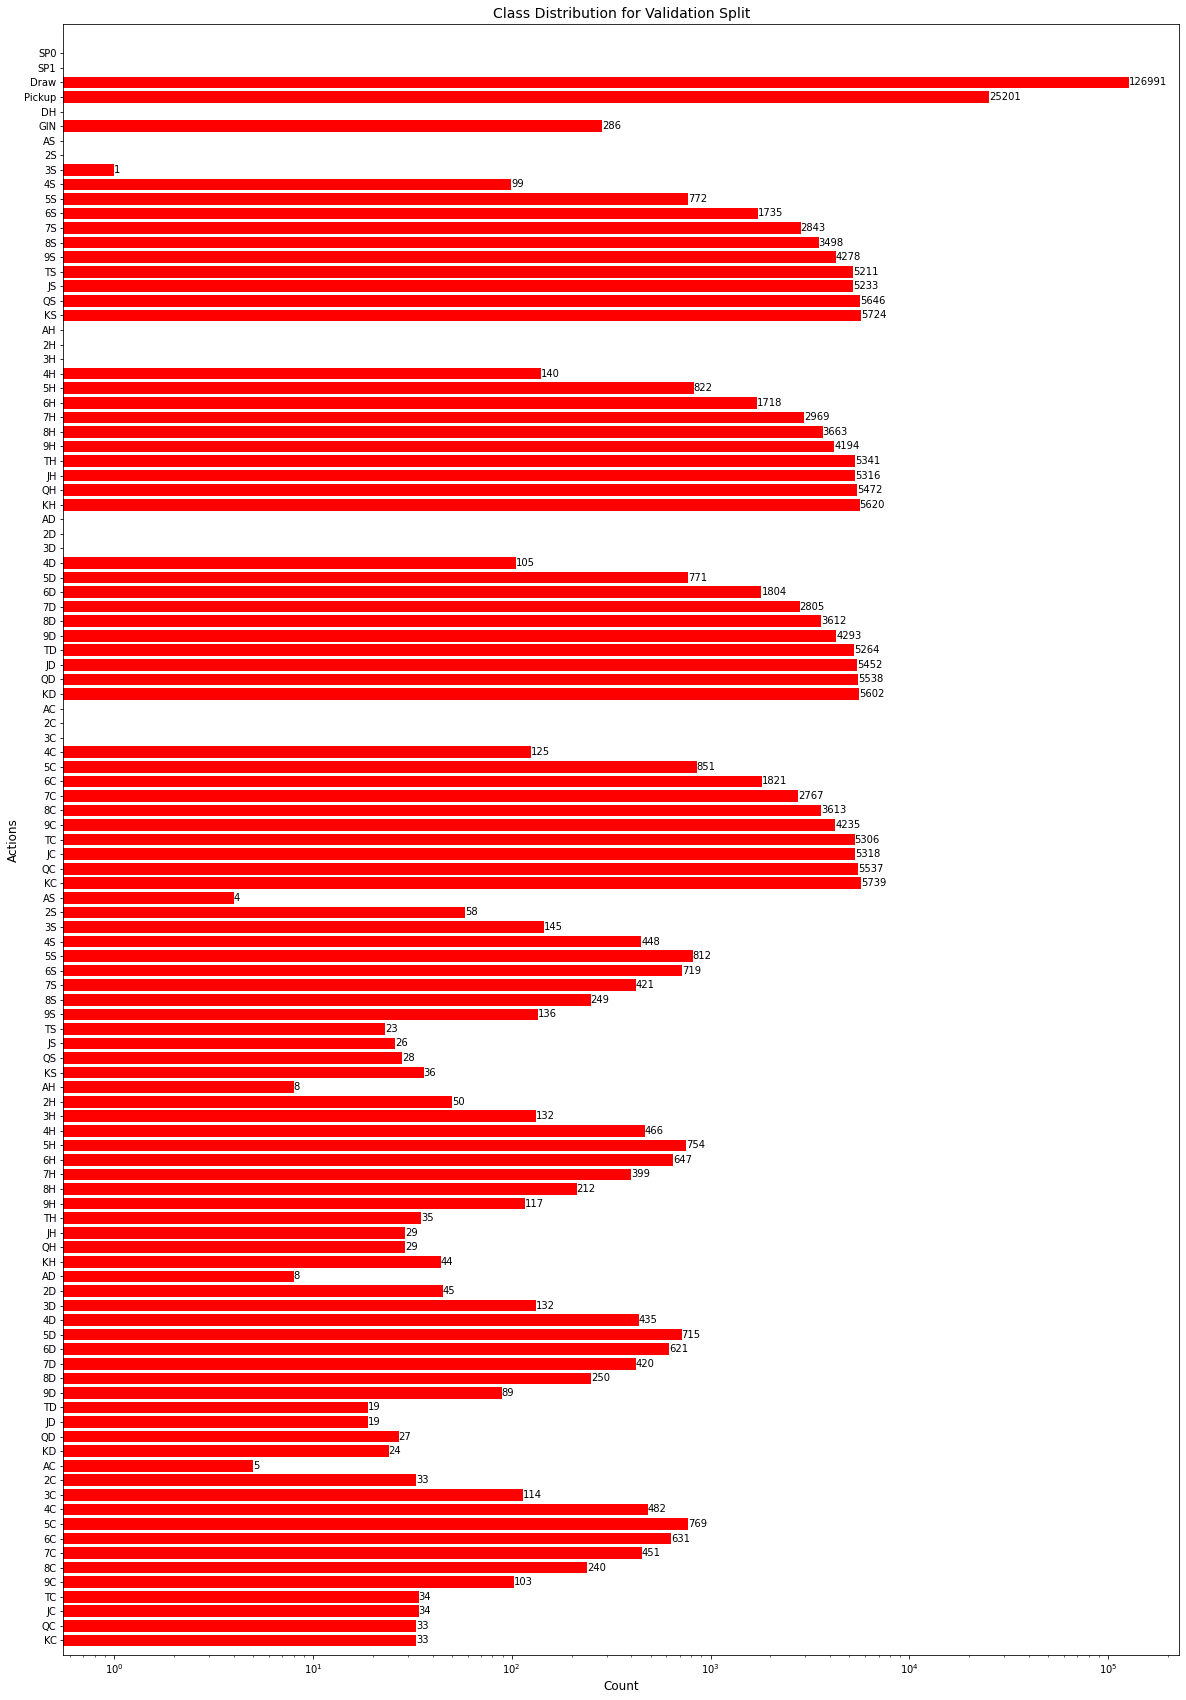

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=True)

### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00591928 | Train acc: 0.492790
              Val Loss: 0.00438910 |   Val acc: 0.624923
Epoch: 2 | Train Loss: 0.00398621 | Train acc: 0.673561
              Val Loss: 0.00371477 |   Val acc: 0.706677
Epoch: 3 | Train Loss: 0.00361394 | Train acc: 0.714980
              Val Loss: 0.00355776 |   Val acc: 0.716754
Epoch: 4 | Train Loss: 0.00351636 | Train acc: 0.721519
              Val Loss: 0.00348541 |   Val acc: 0.722457
Epoch: 5 | Train Loss: 0.00343291 | Train acc: 0.728152
              Val Loss: 0.00342042 |   Val acc: 0.729500
Epoch: 6 | Train Loss: 0.00335619 | Train acc: 0.733520
              Val Loss: 0.00334787 |   Val acc: 0.732535
Epoch: 7 | Train Loss: 0.00328823 | Train acc: 0.738366
              Val Loss: 0.00327546 |   Val acc: 0.738424
Epoch: 8 | Train Loss: 0.00321694 | Train acc: 0.743160
              Val Loss: 0.00319362 |   Val acc: 0.744061
Epoch: 9 | Train Loss: 0.00312764 | Train acc: 0.749416
              Val Loss: 0.00310847 |   V

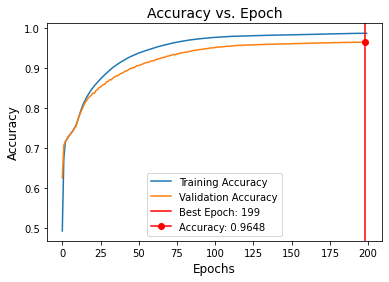

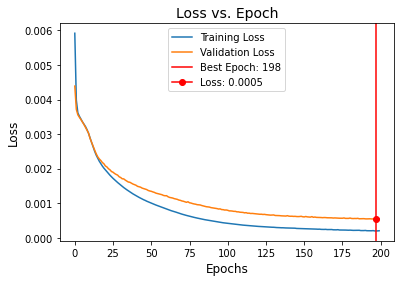

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 98.03
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 98.03
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 98.02
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.98
Normalized confusion matrix


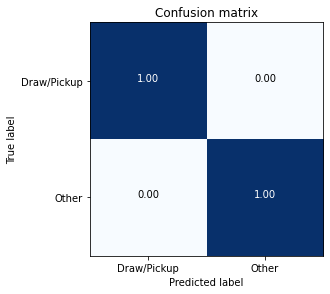

Confusion matrix, without normalization


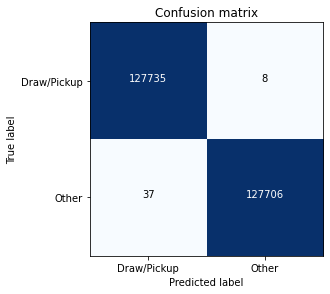

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.37
Normalized confusion matrix


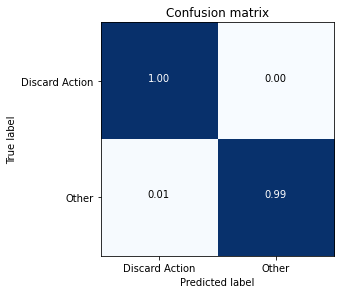

Confusion matrix, without normalization


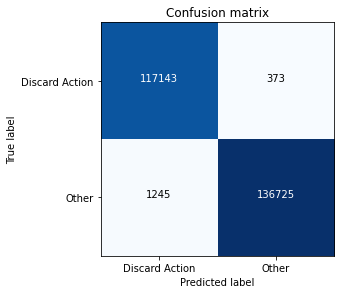

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.36
Normalized confusion matrix


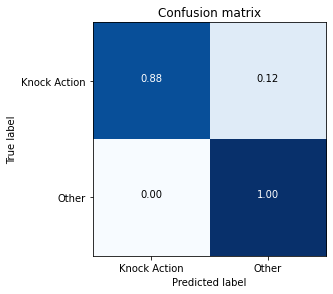

Confusion matrix, without normalization


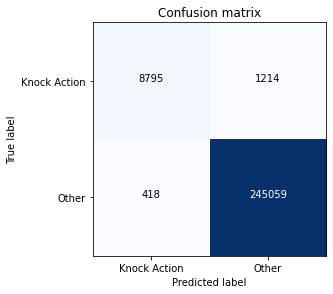

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

## all_states_all_actions_PT

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_PT'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = True
model_PT = '/content/drive/MyDrive/Colab Notebooks/Thesis/models/apbd/knock/all_states_all_actions/model.pt'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth {'First Path': data_path_1,
#                 'Second Path': data_path_2,
#                 ...}
# ex. multi_data_pth = {'data_pth1': '{}/data/{}/{}'.format(pth,'apbd','knock')}
# where data_path_x is of the form {pth}/data/{state}/{action}
# and state/action are legal state_action pairs
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00617670 | Train acc: 0.489825
              Val Loss: 0.00471699 |   Val acc: 0.638907
Epoch: 2 | Train Loss: 0.00402308 | Train acc: 0.696065
              Val Loss: 0.00368806 |   Val acc: 0.718115
Epoch: 3 | Train Loss: 0.00348201 | Train acc: 0.731370
              Val Loss: 0.00339782 |   Val acc: 0.736114
Epoch: 4 | Train Loss: 0.00327266 | Train acc: 0.746237
              Val Loss: 0.00325119 |   Val acc: 0.747342
Epoch: 5 | Train Loss: 0.00311352 | Train acc: 0.759378
              Val Loss: 0.00310041 |   Val acc: 0.759318
Epoch: 6 | Train Loss: 0.00294300 | Train acc: 0.774490
              Val Loss: 0.00296679 |   Val acc: 0.769858
Epoch: 7 | Train Loss: 0.00279482 | Train acc: 0.787561
              Val Loss: 0.00284558 |   Val acc: 0.781286
Epoch: 8 | Train Loss: 0.00266625 | Train acc: 0.799033
              Val Loss: 0.00274750 |   Val acc: 0.787958
Epoch: 9 | Train Loss: 0.00253898 | Train acc: 0.809568
              Val Loss: 0.00264091 |   V

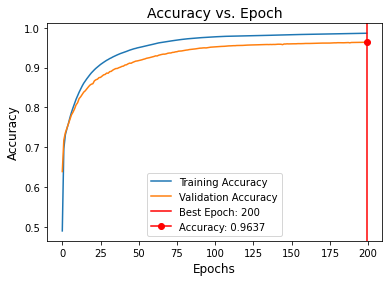

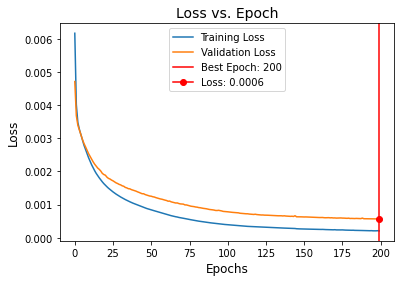

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 97.95
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 97.95
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 97.95
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.98
Normalized confusion matrix


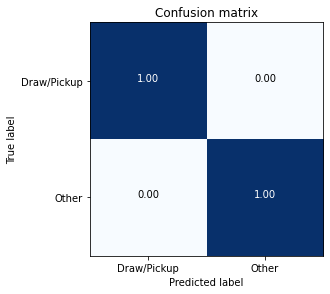

Confusion matrix, without normalization


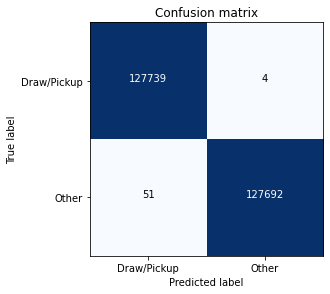

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.49
Normalized confusion matrix


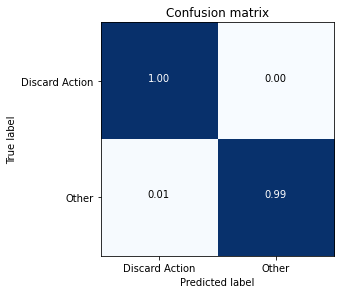

Confusion matrix, without normalization


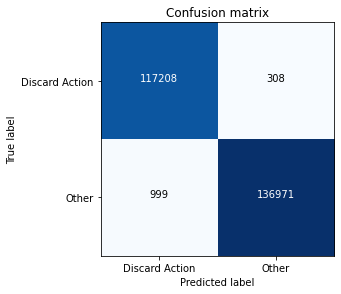

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.49
Normalized confusion matrix


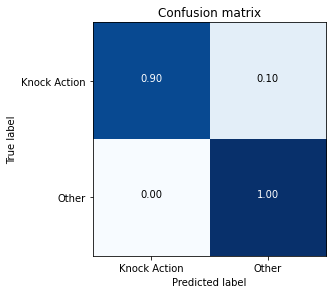

Confusion matrix, without normalization


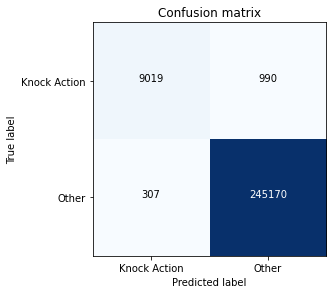

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

## all_states_all_actions CE_Loss Function, icf weighted loss 

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_CE_icf'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.01
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'CELoss'
loss_weight = 'icf'

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth {'First Path': data_path_1,
#                 'Second Path': data_path_2,
#                 ...}
# ex. multi_data_pth = {'data_pth1': '{}/data/{}/{}'.format(pth,'apbd','knock')}
# where data_path_x is of the form {pth}/data/{state}/{action}
# and state/action are legal state_action pairs
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 4.64417910 | Train acc: 0.084229
              Val Loss: 4.61526632 |   Val acc: 0.114881
Epoch: 2 | Train Loss: 4.60183956 | Train acc: 0.125998
              Val Loss: 4.58585119 |   Val acc: 0.140517
Epoch: 3 | Train Loss: 4.57505370 | Train acc: 0.154806
              Val Loss: 4.56135654 |   Val acc: 0.166477
Epoch: 4 | Train Loss: 4.55131068 | Train acc: 0.178375
              Val Loss: 4.53805304 |   Val acc: 0.188805
Epoch: 5 | Train Loss: 4.53032796 | Train acc: 0.198112
              Val Loss: 4.52378893 |   Val acc: 0.199971
Epoch: 6 | Train Loss: 4.51392322 | Train acc: 0.211151
              Val Loss: 4.50477457 |   Val acc: 0.211521
Epoch: 7 | Train Loss: 4.49853824 | Train acc: 0.219851
              Val Loss: 4.48954010 |   Val acc: 0.220648
Epoch: 8 | Train Loss: 4.48535293 | Train acc: 0.226937
              Val Loss: 4.47679853 |   Val acc: 0.224260
Epoch: 9 | Train Loss: 4.47129530 | Train acc: 0.230337
              Val Loss: 4.46568012 |   V

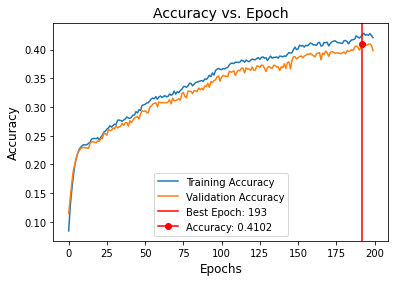

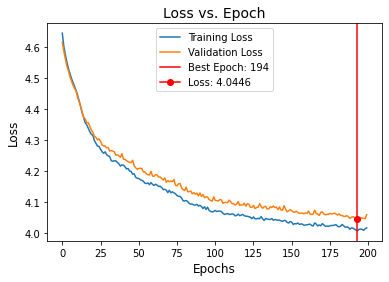

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 41.17
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 42.43
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 42.29
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 50.00
Normalized confusion matrix


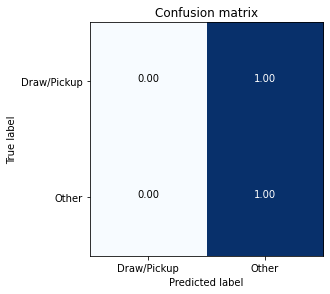

Confusion matrix, without normalization


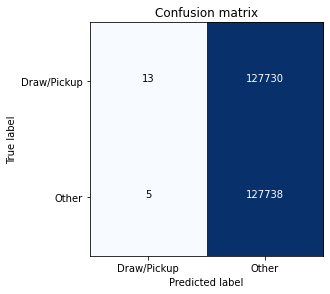

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 65.34
Normalized confusion matrix


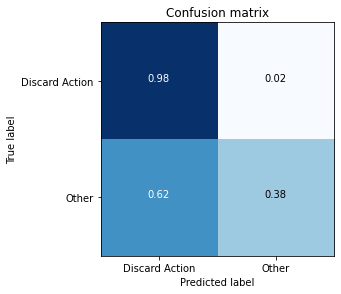

Confusion matrix, without normalization


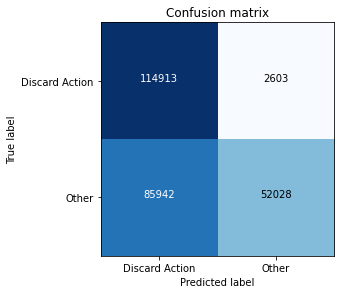

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 81.98
Normalized confusion matrix


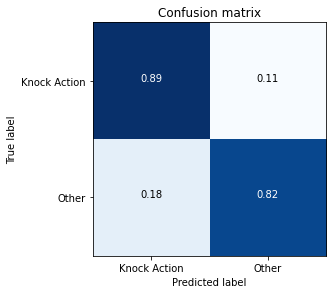

Confusion matrix, without normalization


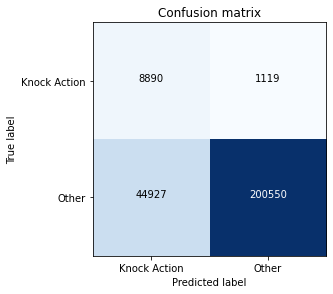

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

## all_states_all_actions CE_Loss Function, log_icf weighted loss 

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_CE_log_icf'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 100

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'CELoss'
loss_weight = 'log_icf'

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth {'First Path': data_path_1,
#                 'Second Path': data_path_2,
#                 ...}
# ex. multi_data_pth = {'data_pth1': '{}/data/{}/{}'.format(pth,'apbd','knock')}
# where data_path_x is of the form {pth}/data/{state}/{action}
# and state/action are legal state_action pairs
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 4.36903330 | Train acc: 0.414993
              Val Loss: 4.36569023 |   Val acc: 0.416195
Epoch: 2 | Train Loss: 4.36390429 | Train acc: 0.418369
              Val Loss: 4.36568928 |   Val acc: 0.416195
Epoch: 3 | Train Loss: 4.36391115 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 4 | Train Loss: 4.36390600 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 5 | Train Loss: 4.36390326 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 6 | Train Loss: 4.36390737 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 7 | Train Loss: 4.36391458 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 8 | Train Loss: 4.36390703 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 9 | Train Loss: 4.36391355 | Train acc: 0.418369
              Val Loss: 4.36568689 |   V

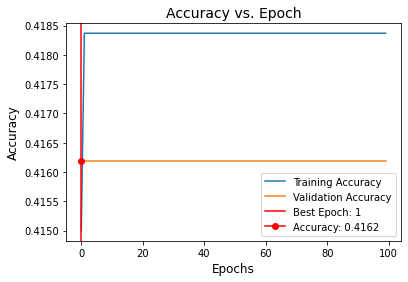

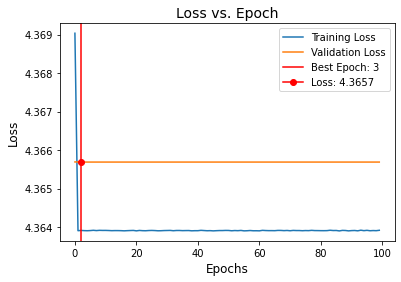

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 41.77
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 41.77
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 41.77
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 50.00
Normalized confusion matrix


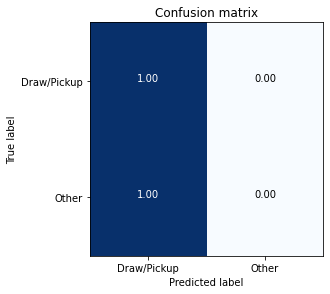

Confusion matrix, without normalization


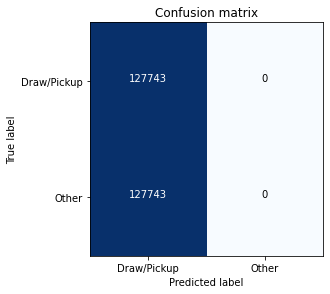

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 54.00
Normalized confusion matrix


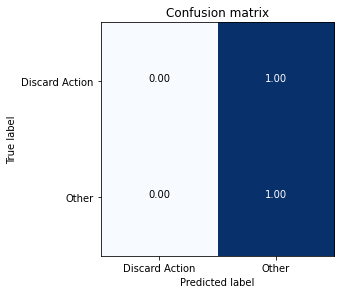

Confusion matrix, without normalization


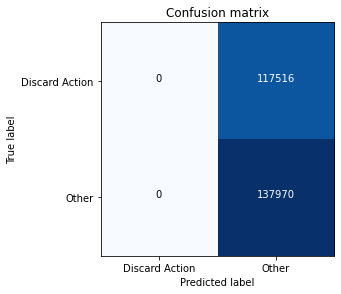

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 96.08
Normalized confusion matrix


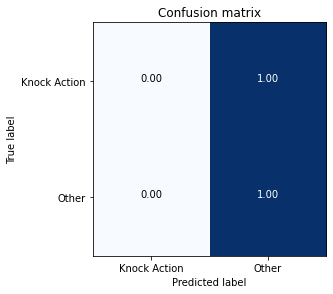

Confusion matrix, without normalization


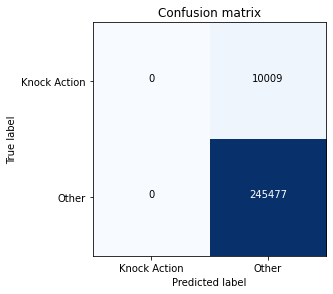

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

## all_states_all_actions_2HL

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_2HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth {'First Path': data_path_1,
#                 'Second Path': data_path_2,
#                 ...}
# ex. multi_data_pth = {'data_pth1': '{}/data/{}/{}'.format(pth,'apbd','knock')}
# where data_path_x is of the form {pth}/data/{state}/{action}
# and state/action are legal state_action pairs
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00637100 | Train acc: 0.421942
              Val Loss: 0.00563129 |   Val acc: 0.427554
Epoch: 2 | Train Loss: 0.00557441 | Train acc: 0.450407
              Val Loss: 0.00551973 |   Val acc: 0.480595
Epoch: 3 | Train Loss: 0.00468898 | Train acc: 0.589882
              Val Loss: 0.00412690 |   Val acc: 0.648343
Epoch: 4 | Train Loss: 0.00388505 | Train acc: 0.675245
              Val Loss: 0.00369159 |   Val acc: 0.696009
Epoch: 5 | Train Loss: 0.00358062 | Train acc: 0.707981
              Val Loss: 0.00350355 |   Val acc: 0.714768
Epoch: 6 | Train Loss: 0.00341682 | Train acc: 0.722136
              Val Loss: 0.00339903 |   Val acc: 0.722238
Epoch: 7 | Train Loss: 0.00327459 | Train acc: 0.733683
              Val Loss: 0.00324543 |   Val acc: 0.737454
Epoch: 8 | Train Loss: 0.00313077 | Train acc: 0.745983
              Val Loss: 0.00309185 |   Val acc: 0.745267
Epoch: 9 | Train Loss: 0.00294783 | Train acc: 0.761027
              Val Loss: 0.00296116 |   V

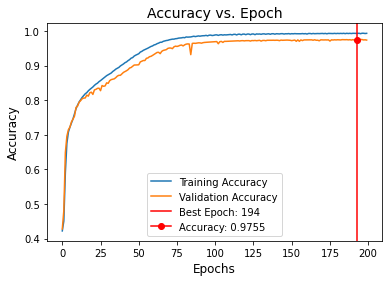

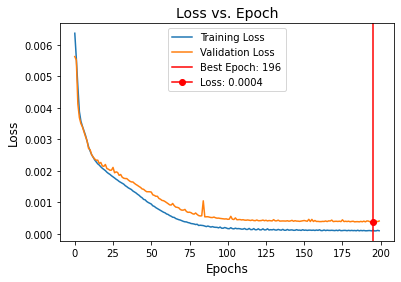

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.29
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 98.71
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 98.81
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 98.82
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.99
Normalized confusion matrix


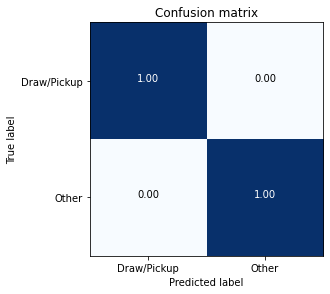

Confusion matrix, without normalization


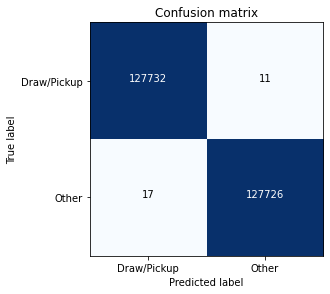

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.57
Normalized confusion matrix


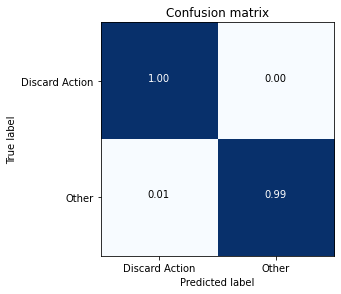

Confusion matrix, without normalization


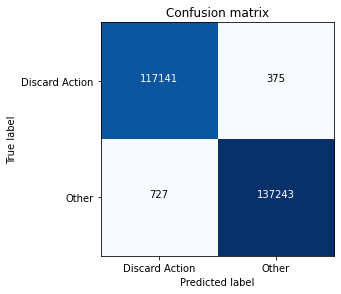

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.58
Normalized confusion matrix


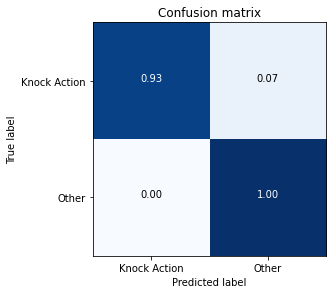

Confusion matrix, without normalization


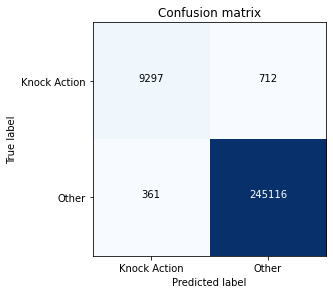

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader_2k, classes = load_test_data(data_pth_discard, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, mode='knock_data_only')

Accuracy: 98.22
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (8k)

In [ ]:
currGames = 8000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader_2k, classes = load_test_data(data_pth_knock, currGames, state, action,
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, mode='knock_data_only')

Accuracy: 92.00
Normalized confusion matrix
Confusion matrix, without normalization
